---

# For reviewers, please follow the notebook using `nbviewer`

# (copypaste the full github URL of this notebook in [http://nbviewer.jupyter.org/](http://nbviewer.jupyter.org/))

---

# HW5 ADA - Text taming

Table of contents : 
    1. About word clouds
        1.1. Using raw corpus
        1.2. Using NLP processed data
    2. About Sentiment Analysis
        2.1. Getting e-mails that talk about countries
        2.2. Visualization
    3. Topic Extraction
        3.1. Manual judgement
        3.2. Using likelihoods
    4. Bonus (NetworkX)

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

# 1 - About word clouds

> Generate a word cloud based on the raw corpus -- I recommend you to use the Python word_cloud library. With the help of nltk (already available in your Anaconda environment), implement a standard text pre-processing pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and cons (if any) of the two word clouds you generated.

In [2]:
from wordcloud import WordCloud

## 1.1 - Using the raw corpus

We want to use the email contents to do a wordcloud of it. But no pre-processing on the words should be done. We just  use the columns `ExtractedSubject` and `ExtractedBodyText`. Let's import the data as strings and clean it.

In [3]:
data = pd.read_csv("hillary-clinton-emails/Emails.csv", index_col=0)
data = data[["ExtractedSubject", "ExtractedBodyText"]]
data = data.astype(str)
data = data.replace(to_replace="nan", value=" ")

In [4]:
data.head()

,ExtractedSubject,ExtractedBodyText
Id,,
1,FW: Wow,
2,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
3,Re: Chris Stevens,Thx
4,FVV: Cairo Condemnation - Final,
5,,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


We concatenate the two first columns to get the final raw text column `Raw`

In [5]:
data["Raw"] = data.ExtractedSubject.str.cat(data.ExtractedBodyText, sep=" ")

In [6]:
data.head()

,ExtractedSubject,ExtractedBodyText,Raw
Id,,,
1,FW: Wow,,FW: Wow
2,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...","B6\nThursday, March 3, 2011 9:45 PM\nH: Late..."
3,Re: Chris Stevens,Thx,Re: Chris Stevens Thx
4,FVV: Cairo Condemnation - Final,,FVV: Cairo Condemnation - Final
5,,"H <hrod17@clintonemail.com>\nFriday, March 11,...","H <hrod17@clintonemail.com>\nFriday, March 1..."


Let's concatenate all the values now using the `join()` method.

In [7]:
text = " ".join(data.Raw.values)

We can already use the wordcloud library, making sure no NLP pre-processing is done by specifying `stopwords=[]` and we make it fancy with a US eagle mask!

In [8]:
from PIL import Image
mask = np.array(Image.open("mask.png"))

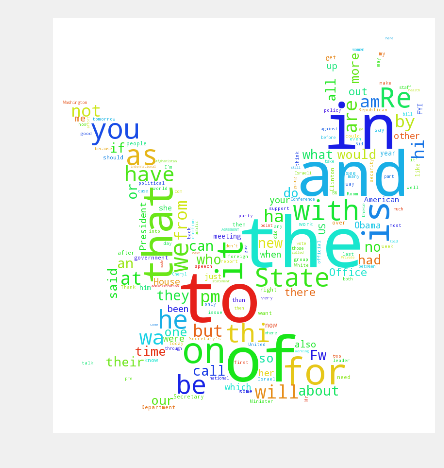

In [9]:
wordcloud = WordCloud(stopwords=[], background_color="white", mask=mask).generate(text)  # generate a word cloud image
plt.figure(figsize=(5,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This first wordcloud, by default, displays word sizes proportionally to frequency, which prevents from seeing a lot of them. Let's first adjust this using `max_font_size=40`

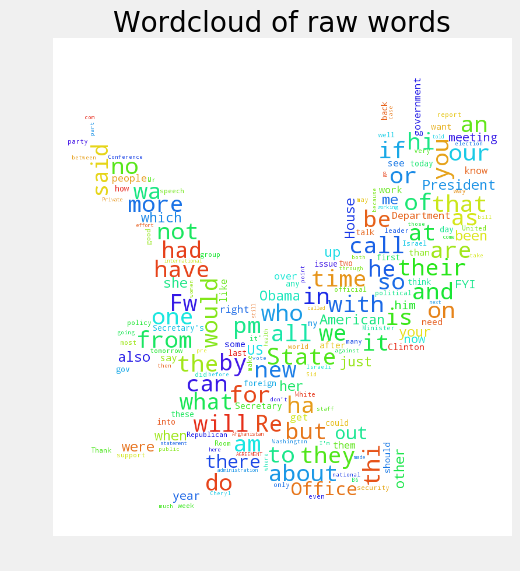

In [10]:
wordcloud = WordCloud(max_font_size=40, stopwords=[], background_color="white", mask=mask).generate(text)
plt.figure(figsize=(6,6))
plt.title("Wordcloud of raw words")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Now, besides the display issues, we must acknowledge that most words __don't bring any information__ such as the, oh, in, and, he, are etc... Indeed, this is very typical of the Zipf's law, clearly observable when plotting word frequencies below :

#### Zipf's law

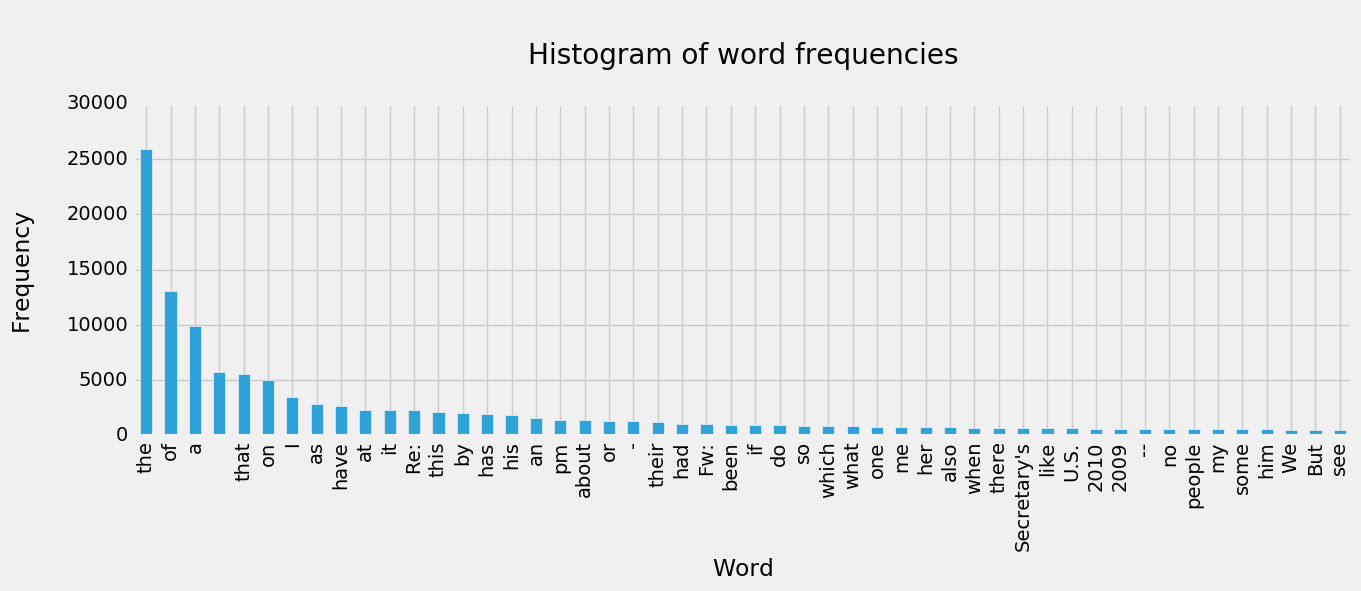

In [11]:
pd.DataFrame(data=" ".join(data.Raw).split(" ")).apply(pd.value_counts)[:100:2].plot(
    kind='bar', title="\nHistogram of word frequencies\n", legend=False, figsize=(14,4));
plt.ylabel("Frequency\n")
plt.xlabel("Word")
plt.xticks(rotation=90);

We can indeed see that the distribution of word frequencies has a real exponential decrease because some words have a very high frequency but give no meaning (ex: stop words).

Something else can be discovered when checking this distribution, but this time looking at the tail. 

In [12]:
pd.Series(data=" ".join(data.Raw).split(" ")).value_counts()[:-10:-1]

madness\nincarnate.     1
female.\nWe             1
AFB\n2:35               1
and\nrun                1
positive;               1
continued\nAmerican     1
been\nimproved          1
extremely\ndifficult    1
for\nsuccess.           1
dtype: int64

Indeed, without cleaning the texts, there are some punctuations, \n or noise things that really prevent to get a good tokenization and insight on what is being said on the e-mails.  

So now we really need to do some NLP processing to our text!

## 1.2 - Using NLP tools to pre-process

We want to pre-process these data with Natural Language Processing, having the **bag of words** approach : texts are actually only sets of words, whatever the words orders. The NLP pipeline we will use is the following :
    - Normalize (lower capital)
    - Tokenize
    - Do Part-of-Speech tagging
    - Get rid of stop words and some tagged PoS
    - Stemmatize the remaining words

In [13]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import stop_words
import string

Let's start by initializing the stemmer and lemmatizer, and defining few functions to enable lemmatizing and stemming

In [14]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [15]:
from nltk.corpus import wordnet

def get_wordnet_tag(treebank_tag):
    """ enables to map pos tags from treebank to wordnet valid pos tags 
    (in order to feed the lemmatizer) """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:  # if starts with N or others (noun by default)
        return wordnet.NOUN

In [16]:
def lemmatize(token):
    """ final method to lemmatize using wordnet lemmatizer """
    
    trbk_tag = pos_tag([token])[0][1]  # get the treebank tag from pos_tag method
    wrdnt_tag = get_wordnet_tag(treebank_tag=trbk_tag)  # translate it to wordnet tag
    return lemmatizer.lemmatize(token, wrdnt_tag)

The lemmatizer enables to find the root of the word. But it is pretty smart as it takes into account the PoS (see in the function above). As a result, for a word like `loving`, it finds that the root is `love`.

In [17]:
lemmatize("loving")

'love'

We can also import english stop words from the library stop_words

In [18]:
stop_words_ = stop_words.get_stop_words("en")

Let's append some stop words that are not in our library : this is a very specific case of e-mails and some keywords like fw, re are very frequent, but bring no information.

In [19]:
stop_words_ += ["re", "fw", "fyi", "pm"]

We will have to remove punctuation using a filter defined below

In [20]:
punctuation_filter = str.maketrans({key: None for key in string.punctuation})

Now let's put all our NLP pipeline into a function `nlp_pre_process()` 

In [21]:
def nlp_pre_process(text, lemma=False, stem=False):
    """
    Reduces an input text into a list of tokens, 
    using NLP filterings such as normalization, 
    PoS and stop word filtering, stemming.
    text: (str)
    tokens: list(str)
    """
    text = text.lower()  # normalize
    text = text.translate(punctuation_filter)  # remove punctuation
    tokens = word_tokenize(text)  # tokenize
    pos_tags = [pos_tag([t]) for t in tokens]  # PoS tagging
    tokens = [token for [(token, tag)] in pos_tags if tag != "DT"]  # PoS filtering
    tokens = [t for t in tokens if t not in stop_words_]  # stop words filtering
    
    if stem:
        tokens = [stemmer.stem(t) for t in tokens]  # stemming
    
    if lemma:
        tokens = [lemmatize(t) for t in tokens]  # lemmatizing
    
    return " ".join(tokens)

Applying these functions : (commented because it is slow)

In [22]:
#data["Stem"] = data.Raw.apply(lambda t: nlp_pre_process(t, stem=True))

In [23]:
#data["Lemma"] = data.Raw.apply(lambda t: nlp_pre_process(t, lemma=True))

In [24]:
data = pd.read_csv("data.csv", index_col=0).drop(
    ["PositiveScore", "NegativeScore", "NeutralScore","CompoundScore"], axis=1).astype(str)

In [25]:
data.head()

,ExtractedSubject,ExtractedBodyText,Raw,Stem,Lemma
Id,,,,,
1,FW: Wow,,FW: Wow,wow,wow
2,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...","B6\nThursday, March 3, 2011 9:45 PM\nH: Late...",b6 thursday march 3 2011 945 h latest syria ai...,b6 thursday march 3 2011 945 h late syria aid ...
3,Re: Chris Stevens,Thx,Re: Chris Stevens Thx,chri steven thx,chris stevens thx
4,FVV: Cairo Condemnation - Final,,FVV: Cairo Condemnation - Final,fvv cairo condemn final,fvv cairo condemnation final
5,,"H <hrod17@clintonemail.com>\nFriday, March 11,...","H <hrod17@clintonemail.com>\nFriday, March 1...",h hrod17clintonemailcom friday march 11 2011 1...,h hrod17clintonemailcom friday march 11 2011 1...


In [26]:
data.head()

,ExtractedSubject,ExtractedBodyText,Raw,Stem,Lemma
Id,,,,,
1,FW: Wow,,FW: Wow,wow,wow
2,,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...","B6\nThursday, March 3, 2011 9:45 PM\nH: Late...",b6 thursday march 3 2011 945 h latest syria ai...,b6 thursday march 3 2011 945 h late syria aid ...
3,Re: Chris Stevens,Thx,Re: Chris Stevens Thx,chri steven thx,chris stevens thx
4,FVV: Cairo Condemnation - Final,,FVV: Cairo Condemnation - Final,fvv cairo condemn final,fvv cairo condemnation final
5,,"H <hrod17@clintonemail.com>\nFriday, March 11,...","H <hrod17@clintonemail.com>\nFriday, March 1...",h hrod17clintonemailcom friday march 11 2011 1...,h hrod17clintonemailcom friday march 11 2011 1...


In [27]:
text_processed_stem = " ".join(data.Stem.values)
text_processed_lemma = " ".join(data.Lemma.values)

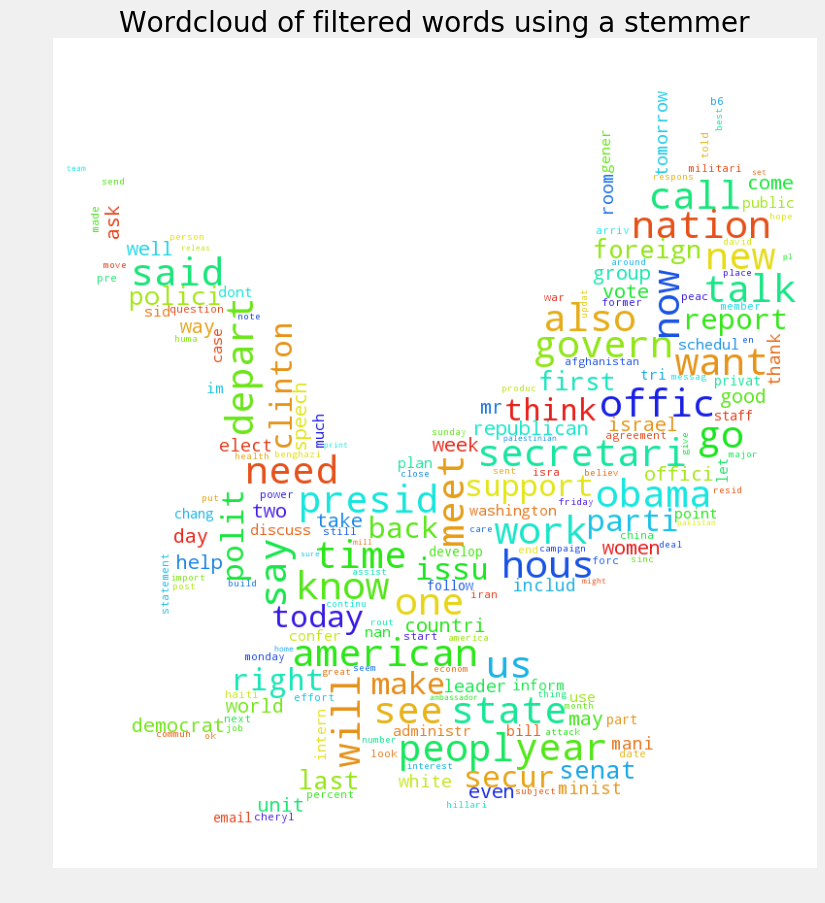

In [28]:
wordcloud = WordCloud(max_font_size=40, background_color="white", mask=mask).generate(text_processed_stem) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Wordcloud of filtered words using a stemmer")
plt.axis("off")
plt.show()

Well the good thing is there are less useless words using a stemmer, but some of the remaining words are not very pleasent : "hous", "secretari", "offic"... This is a drawback of stemming : the operation is pretty harsh and leaves some words that actually do not exist. Although we understand what it means

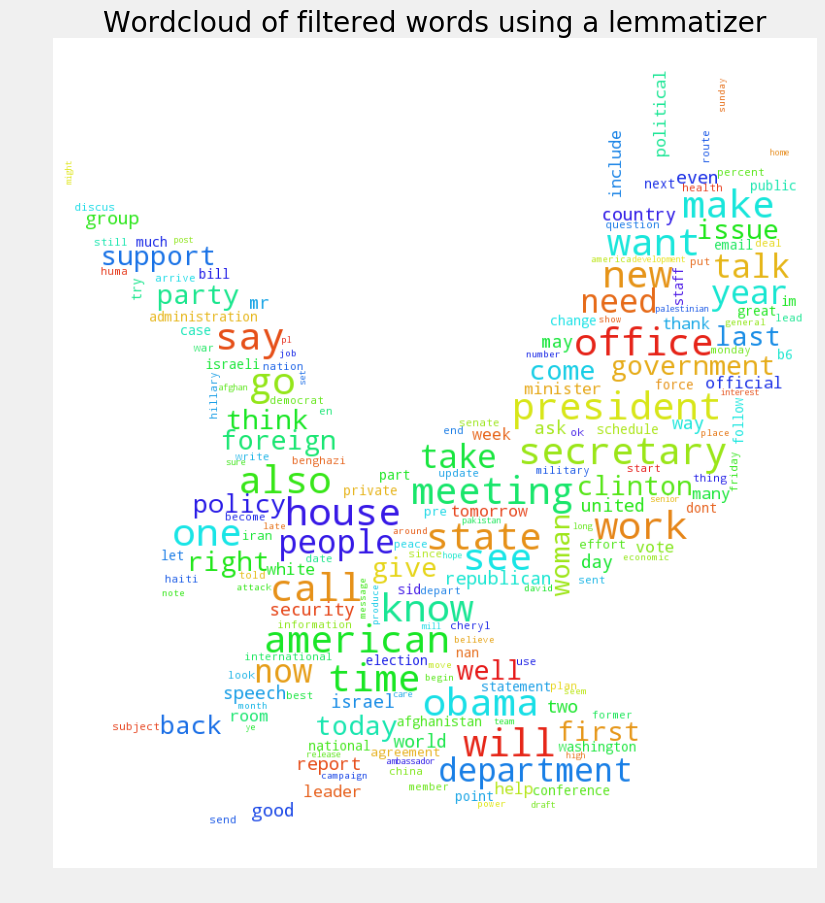

In [29]:
wordcloud = WordCloud(max_font_size=40, background_color="white", mask=mask).generate(text_processed_lemma)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Wordcloud of filtered words using a lemmatizer")
plt.axis("off")
plt.show()

Using the lemmatizer, we actually manage to find the words lemmes given their part of speech tag, and that's often very accurate and the good point is that the words all actually belong to the english language in the end! 

So at least this wordcloud is clean. Now one can always question how much information a wordcloud brings. In this case, we could argue that there's little to catch from this wordcloud, as it's a very narrow look on the whole data, and most of words could have been expected. And here, on this dataset, we really want to find unexpected things.

### Part 1 summary

Wordcloud pros :  
- very easy to do
- very talkative and fancy visualization, people can understand easily

Wordclous cons :
- narrow view of the whole data : if the goal is to find surprising things, wordclouds may not be a good tool

Best NLP pipeline with a __lemmatizer__

# 2. About Sentiment Analysis

> Find all the mentions of world countries in the whole corpus, using the pycountry utility (HINT: remember that there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) Perform sentiment analysis on every email message using the demo methods in the nltk.sentiment.util module. Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?

We'll use the NLTK Vader Sentiment Analysis tools

In [30]:
#nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pycountry
import seaborn as sns

Let's see how it works :

In [31]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores("this homework is an awesome homework")

{'compound': 0.6249, 'neg': 0.0, 'neu': 0.549, 'pos': 0.451}

We get scores for compound, negativity, neutrality and positivity. In our case, it seems to work, as the compound is strong and the positive score is pretty strong too. 

Let's apply this intensity analyzer to our corpus. One question to ask is : should we use it on the raw data or on the processed data... ? Let's start with the raw data we obtained with a lemmatizer.

In [32]:
polarity_scores = [sid.polarity_scores(t) for t in data.Lemma.values]

In [33]:
data["PositiveScore"] = [s["pos"] for s in polarity_scores]
data["NegativeScore"] = [s["neg"] for s in polarity_scores]
data["NeutralScore"] = [s["neu"] for s in polarity_scores]
data["CompoundScore"] = [s["compound"] for s in polarity_scores]

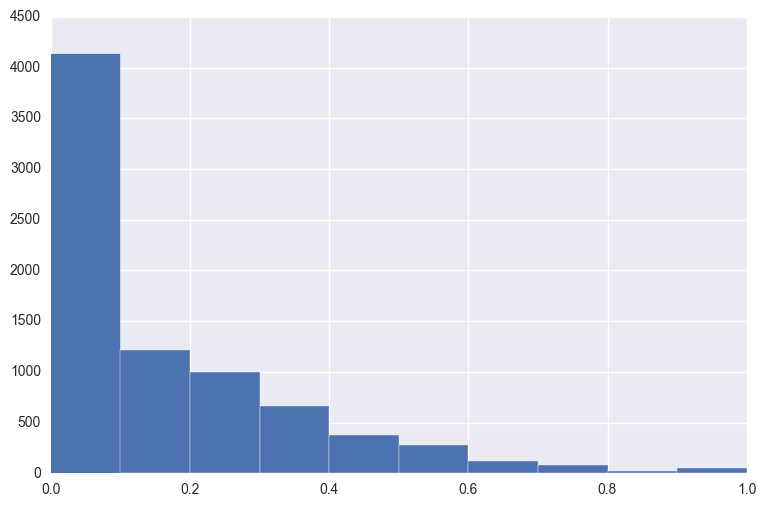

In [34]:
data.PositiveScore.hist()

What are the e-mails scored very positive ?

In [35]:
data[data.PositiveScore>=0.8].drop_duplicates().head(3)

,ExtractedSubject,ExtractedBodyText,Raw,Stem,Lemma,PositiveScore,NegativeScore,NeutralScore,CompoundScore
Id,,,,,,,,,
1,FW: Wow,,FW: Wow,wow,wow,1.0,0.0,0.0,0.5859
57,FW: thanks,,FW: thanks,thank,thanks,1.0,0.0,0.0,0.4404
146,FW: Thanks,,FW: Thanks,thank,thanks,1.0,0.0,0.0,0.4404


Seems to work for positive scores :) How about negative?

In [36]:
data[data.NegativeScore>0.672][["Lemma", "NegativeScore"]].head(7)

,Lemma,NegativeScore
Id,,
349,ill call,0.737
1390,dead aid ffyi,0.683
3212,police bomb kill 5 northwest pakistan,0.725
3529,death,1.000
3571,update death,0.796
4603,idbhaiti debt,0.714
5000,london problem,0.730


Here we realize it works well except for the first one : because of the NLP processing, `I'll` became `ill` which is interpreted as very negative. Which leads to a false-negative ! Let's see if we do it on the raw data

In [37]:
sid.polarity_scores("I'll call her this am.")

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

Works better... It is indeed neutral. Actually thanks to this example we realized the sentiment analysis should be kept on the raw data.  

(commented to avoid slowness)

In [38]:
#polarity_scores = [sid.polarity_scores(t) for t in data.Raw.values]

In [39]:
#data["PositiveScore"] = [s["pos"] for s in polarity_scores]
#data["NegativeScore"] = [s["neg"] for s in polarity_scores]
#data["NeutralScore"] = [s["neu"] for s in polarity_scores]
#data["CompoundScore"] = [s["compound"] for s in polarity_scores]

In [40]:
data = pd.read_csv("data.csv", index_col=0)

## 2.1 Getting the e-mails that talk about countries

Let's get the names of all the countries using `pycountry`. We remove "Jersey" to avoid conflicts with the state New Jersey

In [41]:
countries = [c.name.lower() for c in pycountry.countries if c.name.lower() != "jersey"]

In [42]:
print("There are %s countries" % len(countries))

There are 248 countries


We want to find whether these countries appear in the e-mails. So we define a function `find_countries()` to do just that :

In [43]:
def find_countries(txt):
    """ outputs countries c1,c2,.. found inside 
    a text as a string with format c1 ; c2 ;... """
    
    return ";".join([country for country in countries if country in txt.lower()])

In [44]:
data["Countries"] = data.Raw.astype(str).apply(find_countries)

In [45]:
found_countries = []
for i in data.Countries.values:
    found_countries.append(i.split(";"))
print(len(list(set([item for sublist in found_countries for item in sublist]))), "countries found in the data")

148 countries found in the data


In [46]:
temp=[]
for i, row in enumerate(data[["CompoundScore", "Countries"]].itertuples()):
    countries_found = str(row.Countries).split(";")
    for c in countries_found:
        temp.append({"CompoundScore": row.CompoundScore, "Countries": c})

In [47]:
sentiment_data = pd.DataFrame(temp)

Let's see how the countries presences are distributed in the emails

In [48]:
sentiment_data.groupby("Countries").count().head()

,CompoundScore
Countries,
,6293
afghanistan,126
albania,3
algeria,6
angola,18


So we managed to get scores for many e-mails. In total, 6500 countries occurrences were found in the e-mails. We can see it is not really equally distributed among countries only by looking the head of the dataframe : 
- afghanistan is found 126 times
- albania only 3 times...

We aggregate the compound scores for each country and take the average of it :

In [49]:
countries_sentiment = sentiment_data.groupby("Countries").CompoundScore.mean().sort_values()

In [50]:
countries_sentiment.head()

Countries
united arab emirates   -0.98640
maldives               -0.97695
guinea-bissau          -0.77170
sierra leone           -0.71180
gabon                  -0.71180
Name: CompoundScore, dtype: float64

Let's plot this using a colored bar plot. We define our color palette using `seaborn`. (from red (negative compound) to blue (good compound))

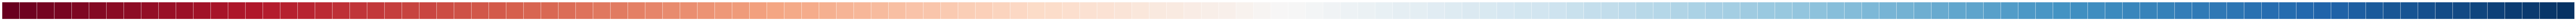

In [51]:
palette = sns.color_palette("RdBu", n_colors=len(countries_sentiment))
sns.palplot(palette)

## 2.2 Final visualizations

We have a lot of countries on the x-axis, but exporting it and opening in somewhere else makes it easier to read. Although we can already see that countries like Monaco, Luxembourg are very high-rated when Honduras or Bemuda have little reputation in Hillary's e-mails

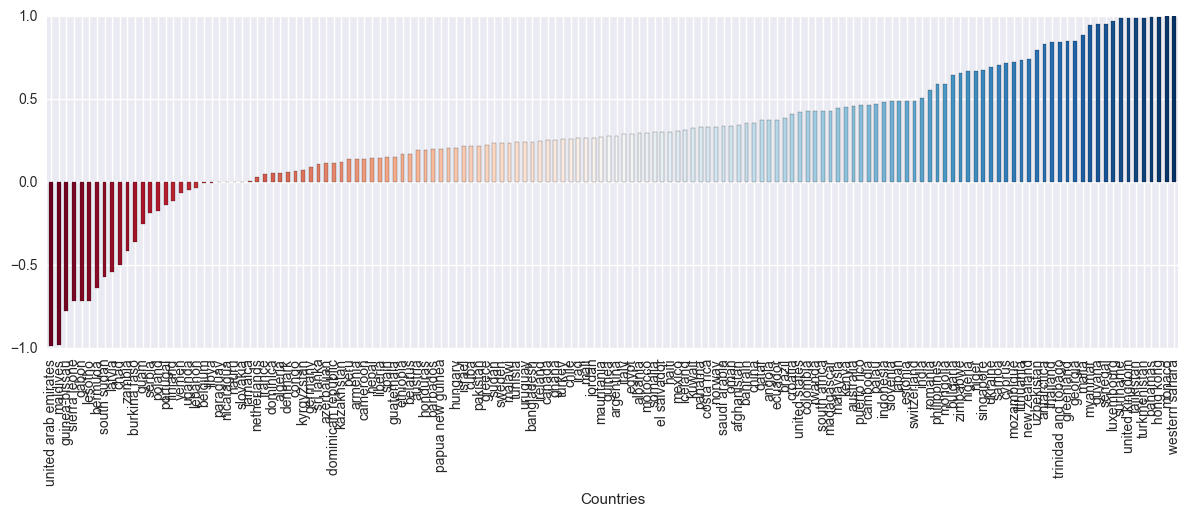

In [52]:
sns.set_context(rc = {'patch.linewidth': 0.15});
countries_sentiment.plot(kind='bar', figsize=(13,4), color= palette, edgecolor="black");

---

### Disclaimer !

We acknowledge the following limits in our pipeline : 
- didn't take into account acronyms, as a result we miss occurrences like "US"... There would still be limits using acronyms like US : the subject 'us' appears a lot in our text and it is not related to the United States. Some conflicts of that kind may appear more than we think on short words such as acronyms, may it be because they have multiple meanings, or because OCR has errors and actually output short words instead of punctuations or whatever..
- didn't either take into account nationalities/adjectives (french, swiss, american...). But one could argue that it makes sense not to count them because they do not necessarily reflect the country's vision but just a local biased vision on one individual/thing that would hardly generalize to the whole country.
- ratings can be very biased by the fact that there are in the end very few mails concerning some countries (e.g albania only 3 e-mails) : we couldn't have serious conclusions on hillary's feeling towards them. One good thing if we wanted to have serious conclusions would be to threshold and keep only countries that have had enough occurrences. Well, we're not doing politics anyway

---

### ->  Improving the unbalanced dataset bias
To overcome the second limit, let's make the visualization take into account the frequency of e-mails found with given countries names in order to have a confidence measure on the sentiment analysis

In [53]:
countries_sent = pd.DataFrame(index=countries_sentiment.index)
countries_sent["score"] = sentiment_data.groupby("Countries").CompoundScore.mean()
countries_sent["count_"] = sentiment_data.groupby("Countries").CompoundScore.count()

In [54]:
countries_sent = countries_sent[countries_sent.index != ""]

In [55]:
def plot_histogram_sentiment(df, size):
    """ plots a histogram with sentiment analysis, credits to Maxime Peschard """
    # Credits to Stack Overflow :
    # http://stackoverflow.com/questions/31313606/pyplot-matplotlib-bar-chart-with-fill-color-depending-on-value
    from matplotlib import cm

    plt.figure(num=None, figsize=size, dpi=80, facecolor='w', edgecolor='k')
    # Set up colors : red to green
    y = np.array(df['score'])
    colors = cm.RdYlGn(y / float(max(y)))
    plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
    plt.clf()
    clb = plt.colorbar(plot)
    clb.ax.set_title("Sentiment")

    # Display bar plot : country frequency vs. country name, with color indicating polarity score
    plt.bar(range(df.shape[0]), countries_sent['count_'], 
            align='center', tick_label=df.index, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Country")
    plt.ylabel("Frequency")
    plt.show()

Keeping all countries, it is hard to read anything. We'll only display countries that appear at leats 10 times in the dataset

In [56]:
COUNT_THRESHOLD = 10

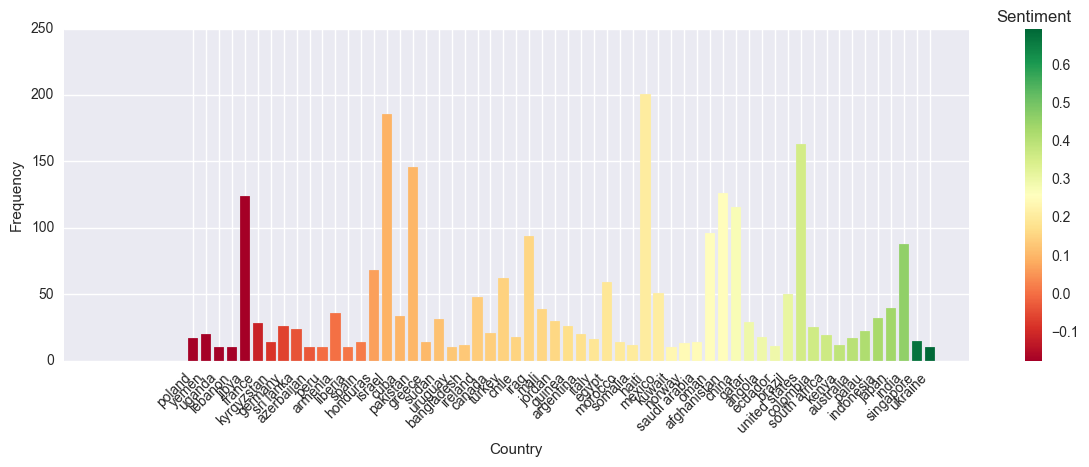

In [90]:
countries_sent = countries_sent[countries_sent.count_ >= COUNT_THRESHOLD]
plot_histogram_sentiment(countries_sent, (13,4))

Now this visualization makes sense! Displays only countries where we have a minimum confidence interval (because more than 10 samples), and turns out that Libya has a very strong confidence with negative sentiment, which makes total sense... Weird for Poland ? 

In [58]:
print(data.set_index("Countries").loc["poland"].Raw.values[1])
print(data.set_index("Countries").loc["poland"].Raw.values[3])
print(data.set_index("Countries").loc["poland"].Raw.values[4])

Fw: (AP) Top Russian official: no missiles near Poland  
Albright Call with Otunbayeva Fyi -- not sure of timing of your call.
Terrible news about Poland.
I'm on the ground and reachable at your convenience.
Re: Tomorrow Abedin, Huma <AbedinH@state.gov>
Sunday, April 18, 2010 6:21 PM
Re: Tomorrow
latest is that nato will make decision tomorrow morning, they don't want to cancel unless they have to and unless we
have other dates to offer. We talked about around poland in July for the alternative.
Phil and I are connecting early tomorrow.
My guess is it will be moved.


That's because of the plane accident with Polish delegation...

# 3. Topic extraction

> Using the models.ldamodel module from the gensim library, run topic modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which returns topics that you consider to be meaningful at first sight.

In [59]:
from gensim.models import LdaModel
from gensim import corpora
import logging
#logging.basicConfig(format='%(message)s', level=logging.INFO)
logging.getLogger("gensim").setLevel(logging.WARNING)

/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [60]:
data.Lemma = data.Lemma.astype(str)

In [61]:
# define a term-document matrix
final_text = [t.split(" ") for t in data.Lemma.values]
dictionary = corpora.Dictionary(final_text)
corpus = [dictionary.doc2bow(text) for text in final_text]

We run LDA model using e-mails as documents, for example for 3 topics we would run it like that. Passing 5 times enable to have more precise results.

In [62]:
# run model
lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=5)

## 3.1 Manual evaluation of topics extraction

Well we are looking for a human-intelligible result so it makes sense to look manually a little at the topics distrubution over words, and see if they highlight some real semantic cluster. 

An interesting way to look at the extracted topics and which words lie inside is to use the library `pyLDAvis` (see below).   
We'll see topic extraction for respectively 3, 8, 15, 30 and 50 topics. 

__NOTE :__ We'll always consider the visualization for the relevance metric $\lambda =0$ (use slider) in order to remove too frequent words that remained even after filtering stop words.

In [63]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, u

#### For 3 topics

In [64]:
n_topics = 3
lda3 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda3, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      60.839635        1       1  0.014411 -0.144675
1      23.027193        1       2 -0.168332  0.062633
0      16.133172        1       3  0.153922  0.082042, topic_info=      Category         Freq           Term        Total  loglift  logprob
term                                                                     
41     Default  1941.000000           call  1941.000000  30.0000  30.0000
20745  Default  1283.000000      secretary  1283.000000  29.0000  29.0000
26862  Default  1070.000000         office  1070.000000  28.0000  28.0000
7312   Default  1845.000000          state  1845.000000  27.0000  27.0000
17084  Default  2537.000000           will  2537.000000  26.0000  26.0000
25226  Default   895.000000              h   895.000000  25.0000  25.0000
21719  Default  1458.000000            can  1458.000000  24.0000  24.0000
13475  Default   667.000000     department   667.000000  23.0000  23.0000
19744  Default   830.000000        meeting   830.000000  22.0000  22.0000
25374  Default   438.000000           room   438.000000  21.0000  21.0000
15811  Default  1144.000000            get  1144.000000  20.0000  20.0000
26964  Default   545.000000              2   545.000000  19.0000  19.0000
1572   Default   822.000000           talk   822.000000  18.0000  18.0000
9833   Default   914.000000            see   914.000000  17.0000  17.0000
26377  Default   547.000000              1   547.000000  16.0000  16.0000
22585  Default   477.000000       tomorrow   477.000000  15.0000  15.0000
11438  Default  1026.000000           2010  1026.000000  14.0000  14.0000
781    Default   376.000000            nan   376.000000  13.0000  13.0000
26348  Default  1917.000000              u  1917.000000  12.0000  12.0000
19096  Default   300.000000         arrive   300.000000  11.0000  11.0000
4562   Default   897.000000           just   897.000000  10.0000  10.0000
23176  Default   270.000000             en   270.000000   9.0000   9.0000
22846  Default   273.000000          route   273.000000   8.0000   8.0000
14889  Default   845.000000           want   845.000000   7.0000   7.0000
13010  Default   265.000000         depart   265.000000   6.0000   6.0000
9128   Default   340.000000        private   340.000000   5.0000   5.0000
20319  Default   406.000000          email   406.000000   4.0000   4.0000
14897  Default   494.000000         united   494.000000   3.0000   3.0000
20550  Default   418.000000             im   418.000000   2.0000   2.0000
2115   Default   493.000000              w   493.000000   1.0000   1.0000
...        ...          ...            ...          ...      ...      ...
26945   Topic3    62.261723         gender    64.771059   1.7848  -6.8733
16265   Topic3    72.911575            200    76.884051   1.7712  -6.7154
26862   Topic3   852.593546         office  1070.779402   1.5964  -4.2564
7770    Topic3    87.749337      favorable    94.386051   1.7514  -6.5302
20745   Topic3   924.284328      secretary  1283.797735   1.4957  -4.1756
25689   Topic3    93.977881           1000   102.458555   1.7379  -6.4616
13475   Topic3   504.023016     department   667.641409   1.5432  -4.7820
26964   Topic3   384.842160              2   545.818116   1.4748  -5.0518
9128    Topic3   248.167294        private   340.807948   1.5071  -5.4905
26377   Topic3   365.464426              1   547.217127   1.4206  -5.1035
3660    Topic3   165.258141          daily   211.968485   1.5754  -5.8971
19744   Topic3   485.055082        meeting   830.678290   1.2863  -4.8204
17606   Topic3   245.448997              3   366.862095   1.4224  -5.5016
7312    Topic3   826.101828          state  1845.107603   1.0207  -4.2879
21646   Topic3   253.923966     conference   392.194129   1.3896  -5.4676
21254   Topic3   198.517919          haiti   317.818989   1.3537  -5.7138
27928   Topic3   168.548098             un   278.459190   1.3

Topic 1 seems to talk about military-related subjects (afghan, arab, nuclear, gaza, mcchrystal...) , while topic 2 is more about politics (tax, labor, amendment, lobbyist...) and topic 3 is a trash topic with e-mails and numbers. So we can say the topic extraction is not bad.

#### For 8 topics

In [65]:
n_topics = 8
lda8 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda8, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      26.896053        1       1 -0.159835 -0.006130
2      21.644777        1       2 -0.153678 -0.001624
5      14.026658        1       3 -0.004040  0.139154
4      13.621604        1       4 -0.123241  0.016612
1       8.047925        1       5 -0.103411 -0.114128
3       6.406391        1       6  0.243667  0.137205
6       5.620455        1       7  0.197827 -0.276314
7       3.736139        1       8  0.102712  0.105225, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
20745  Default  1314.000000    secretary  1314.000000  30.0000  30.0000
41     Default  1895.000000         call  1895.000000  29.0000  29.0000
26862  Default  1092.000000       office  1092.000000  28.0000  28.0000
7312   Default  1926.000000        state  1926.000000  27.0000  27.0000
11438  Default   973.000000         2010   973.000000  26.0000  26.0000
25226  Default   840.000000            h   840.000000  25.0000  25.0000
18717  Default   642.000000       israel   642.000000  24.0000  24.0000
17084  Default  2588.000000         will  2588.000000  23.0000  23.0000
19744  Default   857.000000      meeting   857.000000  22.0000  22.0000
25374  Default   454.000000         room   454.000000  21.0000  21.0000
13475  Default   700.000000   department   700.000000  20.0000  20.0000
21719  Default  1495.000000          can  1495.000000  19.0000  19.0000
26377  Default   526.000000            1   526.000000  18.0000  18.0000
24043  Default   615.000000   republican   615.000000  17.0000  17.0000
26964  Default   529.000000            2   529.000000  16.0000  16.0000
8123   Default   468.000000      israeli   468.000000  15.0000  15.0000
781    Default   413.000000          nan   413.000000  14.0000  14.0000
21592  Default   544.000000         2009   544.000000  13.0000  13.0000
19096  Default   312.000000       arrive   312.000000  12.0000  12.0000
15811  Default  1167.000000          get  1167.000000  11.0000  11.0000
26348  Default  1987.000000            u  1987.000000  10.0000  10.0000
22846  Default   283.000000        route   283.000000   9.0000   9.0000
23176  Default   280.000000           en   280.000000   8.0000   8.0000
3152   Default   742.000000        party   742.000000   7.0000   7.0000
8755   Default   333.000000  palestinian   333.000000   6.0000   6.0000
13010  Default   274.000000       depart   274.000000   5.0000   5.0000
1572   Default   851.000000         talk   851.000000   4.0000   4.0000
9128   Default   349.000000      private   349.000000   3.0000   3.0000
22585  Default   497.000000     tomorrow   497.000000   2.0000   2.0000
17606  Default   352.000000            3   352.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
8375    Topic8    47.509100      traffic    72.879463   2.8592  -5.6809
9595    Topic8   106.085875         list   208.598224   2.6110  -4.8776
7045    Topic8    19.522097        maria    24.113703   3.0759  -6.5703
22472   Topic8    33.160512          min    50.538783   2.8657  -6.0405
41      Topic8   443.738122         call  1895.313130   1.8352  -3.4466
2823    Topic8    20.859077       dennis    26.558805   3.0455  -6.5040
189     Topic8    36.604102   eikenberry    59.455733   2.8020  -5.9417
2054    Topic8    31.535622     district    50.153472   2.8231  -6.0907
941     Topic8    80.995763          yes   226.044176   2.2608  -5.1474
19223   Topic8    82.630213          pls   239.965413   2.2210  -5.1274
4016    Topic8    91.158944       update   309.351204   2.0652  -5.0292
25441   Topic8    28.168571         mail    45.190670   2.8144  -6.2036
22276   Topic8    43.058280         copy   100.607369   2.4384  -5.7793
6239    Topic8    62.981092        print   214.317168   2.0625  -5.3990
16731   Topic8   107.476321      

Topic 1 is clearly about war  
Topic 4 about personalities.   
Other topics make no real sense..

#### For 15 topics

In [66]:
n_topics = 15
lda15 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda15, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
10     27.151193        1       1 -0.210933 -0.067726
3      13.494069        1       2 -0.186780 -0.073334
12     12.028016        1       3 -0.198713 -0.028039
0       9.880321        1       4 -0.187501 -0.013160
5       7.396818        1       5 -0.085476  0.187636
6       5.728645        1       6 -0.033259  0.175343
4       4.931541        1       7  0.103287  0.172365
14      4.709716        1       8  0.122273 -0.210759
13      4.229244        1       9 -0.031540 -0.034075
8       3.683462        1      10  0.038194 -0.139538
7       1.699672        1      11  0.095729  0.095731
2       1.589097        1      12  0.143314  0.043637
9       1.281157        1      13  0.101853  0.002881
1       1.182484        1      14  0.171082 -0.004593
11      1.014567        1      15  0.158469 -0.106368, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
7312   Default  2047.000000       state  2047.000000  30.0000  30.0000
20745  Default  1356.000000   secretary  1356.000000  29.0000  29.0000
41     Default  1939.000000        call  1939.000000  28.0000  28.0000
26862  Default  1138.000000      office  1138.000000  27.0000  27.0000
17084  Default  2558.000000        will  2558.000000  26.0000  26.0000
11438  Default   984.000000        2010   984.000000  25.0000  25.0000
25226  Default   853.000000           h   853.000000  24.0000  24.0000
16676  Default   642.000000           •   642.000000  23.0000  23.0000
26348  Default  2056.000000           u  2056.000000  22.0000  22.0000
16731  Default   798.000000           —   798.000000  21.0000  21.0000
21719  Default  1472.000000         can  1472.000000  20.0000  20.0000
19744  Default   875.000000     meeting   875.000000  19.0000  19.0000
13475  Default   762.000000  department   762.000000  18.0000  18.0000
13209  Default   655.000000       woman   655.000000  17.0000  17.0000
25374  Default   470.000000        room   470.000000  16.0000  16.0000
26377  Default   535.000000           1   535.000000  15.0000  15.0000
26964  Default   536.000000           2   536.000000  14.0000  14.0000
3245   Default   461.000000        vote   461.000000  13.0000  13.0000
781    Default   355.000000         nan   355.000000  12.0000  12.0000
14480  Default   631.000000          mr   631.000000  11.0000  11.0000
15811  Default  1151.000000         get  1151.000000  10.0000  10.0000
1572   Default   823.000000        talk   823.000000   9.0000   9.0000
14582  Default  2085.000000         say  2085.000000   8.0000   8.0000
19096  Default   324.000000      arrive   324.000000   7.0000   7.0000
7651   Default   698.000000     clinton   698.000000   6.0000   6.0000
22585  Default   481.000000    tomorrow   481.000000   5.0000   5.0000
18717  Default   517.000000      israel   517.000000   4.0000   4.0000
26866  Default   414.000000        case   414.000000   3.0000   3.0000
21592  Default   554.000000        2009   554.000000   2.0000   2.0000
9833   Default   902.000000         see   902.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
7643   Topic15     6.657090      random     7.484541   4.4736  -6.3425
25960  Topic15     6.408140         850     7.235782   4.4692  -6.3807
14860  Topic15     6.312240        20th     7.139786   4.4675  -6.3957
17222  Topic15     6.307260         110     7.135114   4.4674  -6.3965
23225  Topic15     6.294810         otr     7.122315   4.4672  -6.3985
10046  Topic15     6.232520    binyamin     7.059940   4.4661  -6.4084
15584  Topic15     6.931595         spy     7.864823   4.4644  -6.3021
27680  Topic15     6.139430         310     6.966703   4.4643  -6.4235
25160  Topic15    10.481734        ehud    12.115670   4.4458  -5.8886
6297   Topic15    12.486822        10am    14.551409   4.

Topic 1 : economy,  
topic 3 : politics,  
topic 8 : e-mail related fields,  
topic 9 : war.  
All others are trash topics

#### For 30 topics

In [67]:
n_topics = 30
lda30 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda30, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
18     19.427690        1       1  0.257591  0.078345
21     17.048947        1       2  0.247397  0.099289
29      9.966882        1       3  0.233376 -0.100740
2       4.564580        1       4 -0.015495  0.003301
3       4.043044        1       5  0.180204  0.092535
24      3.998082        1       6  0.098101 -0.266329
16      3.831142        1       7 -0.059189 -0.023299
26      3.454990        1       8  0.100431  0.072033
17      3.312874        1       9  0.143965  0.038689
8       3.099369        1      10  0.153363  0.164819
1       2.949587        1      11  0.150609  0.012977
15      2.645704        1      12 -0.021194 -0.031807
10      2.522740        1      13  0.033974  0.096128
13      2.406851        1      14  0.087965 -0.171538
9       1.985265        1      15  0.009196 -0.232351
6       1.662396        1      16 -0.001460  0.071010
25      1.446614        1      17 -0.057455 -0.142454
12      1.131768        1      18 -0.082753 -0.091292
0       1.104181        1      19 -0.141746  0.040062
23      1.103913        1      20 -0.149844  0.053338
7       1.073055        1      21 -0.084870  0.111555
22      0.988096        1      22 -0.059669 -0.156280
27      0.981651        1      23 -0.110480 -0.006086
14      0.849672        1      24 -0.122084  0.046393
5       0.820404        1      25 -0.071560  0.008018
11      0.789965        1      26 -0.133502  0.047132
19      0.769507        1      27 -0.108479  0.040895
20      0.765953        1      28 -0.170811  0.095690
4       0.675620        1      29 -0.137395 -0.020792
28      0.579458        1      30 -0.168188  0.070758, topic_info=      Category         Freq               Term        Total  loglift  logprob
term                                                                         
41     Default  1977.000000               call  1977.000000  30.0000  30.0000
7312   Default  2090.000000              state  2090.000000  29.0000  29.0000
17084  Default  2547.000000               will  2547.000000  28.0000  28.0000
26862  Default  1141.000000             office  1141.000000  27.0000  27.0000
20745  Default  1399.000000          secretary  1399.000000  26.0000  26.0000
11438  Default  1016.000000               2010  1016.000000  25.0000  25.0000
26348  Default  2044.000000                  u  2044.000000  24.0000  24.0000
21719  Default  1523.000000                can  1523.000000  23.0000  23.0000
13475  Default   818.000000         department   818.000000  22.0000  22.0000
25226  Default   864.000000                  h   864.000000  21.0000  21.0000
18717  Default   502.000000             israel   502.000000  20.0000  20.0000
16676  Default   629.000000                  •   629.000000  19.0000  19.0000
14582  Default  2065.000000                say  2065.000000  18.0000  18.0000
1572   Default   856.000000               talk   856.000000  17.0000  17.0000
9833   Default   912.000000                see   912.000000  16.0000  16.0000
6696   Default   475.000000             speech   475.000000  15.0000  15.0000
24043  Default   621.000000         republican   621.000000  14.0000  14.0000
19586  Default   378.000000               part   378.000000  13.0000  13.0000
26964  Default   545.000000                  2   545.000000  12.0000  12.0000
3152   Default   749.000000              party   749.000000  11.0000  11.0000
572    Default   369.000000        afghanistan   369.000000  10.0000  10.0000
26377  Default   550.000000                  1   550.000000   9.0000   9.0000
8123   Default   366.000000            israeli   366.000000   8.0000   8.0000
21592  Default   554.000000               2009   554.000000   7.0000   7.0000
19744  Default   896.000000            meeting   896.000000   6.0000   6.0000
25374  Default   497.000000               room   497.000000   5.0000   5.0000
10536  Default   291.000000              chin

Topic 1 : politics (economy)  
Topic 2 : religion (religion, mariage, faith, christian...)  
Topic 6 : personalities  
Topic 8 : emails  
Topic 11 : israel palestine conflict !!  
Topic 17 : mobile email   
Topics 22, 23, 24, 27: personalities  

#### For 50 topics

In [68]:
n_topics = 50
lda50 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=5)
pyLDAvis.gensim.prepare(lda50, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
16     8.955269        1       1  0.283292 -0.021265
20     8.550289        1       2  0.188284  0.205301
35     8.353918        1       3  0.272223 -0.053191
24     7.569291        1       4  0.287016 -0.017939
31     4.759576        1       5  0.243365 -0.101168
21     4.141539        1       6 -0.004774 -0.114292
7      3.998087        1       7  0.223475 -0.076884
32     3.861985        1       8  0.195367 -0.002230
40     3.611643        1       9  0.091927  0.282809
9      3.426747        1      10  0.189367 -0.024572
42     2.991463        1      11  0.142038 -0.017936
17     2.965860        1      12  0.190612 -0.027254
8      2.620380        1      13  0.170686 -0.023207
10     2.324290        1      14  0.156698 -0.083889
18     2.164920        1      15 -0.011330 -0.066881
12     2.052933        1      16  0.124056 -0.086421
0      1.954566        1      17 -0.045981 -0.094170
2      1.577981        1      18 -0.089289  0.065467
38     1.498973        1      19  0.065001  0.172459
27     1.343856        1      20  0.041772  0.033952
6      1.342042        1      21  0.042536  0.017359
15     1.173102        1      22 -0.051952  0.214533
3      1.073062        1      23 -0.041441 -0.073440
36     0.984135        1      24 -0.032837 -0.039397
26     0.954790        1      25 -0.011635  0.131610
39     0.915225        1      26 -0.085339 -0.106309
14     0.899950        1      27 -0.127188 -0.052732
49     0.841033        1      28 -0.057612  0.094293
47     0.835770        1      29 -0.127222  0.052538
45     0.811768        1      30 -0.049616  0.132631
33     0.791452        1      31 -0.117976 -0.070621
25     0.763790        1      32 -0.146294 -0.112174
34     0.737942        1      33 -0.092238  0.103149
5      0.701449        1      34 -0.111132  0.138168
1      0.677476        1      35 -0.041705 -0.163102
28     0.675351        1      36 -0.102696 -0.024511
48     0.658253        1      37 -0.144721 -0.089107
4      0.639988        1      38 -0.095610 -0.036599
13     0.599558        1      39 -0.080163 -0.040542
29     0.592979        1      40 -0.055585  0.081691
43     0.590970        1      41 -0.097783  0.092802
22     0.579910        1      42 -0.107277  0.059643
30     0.555304        1      43 -0.072162 -0.028105
23     0.516819        1      44 -0.079711 -0.005589
11     0.494269        1      45 -0.109044 -0.064290
19     0.411406        1      46 -0.146672 -0.001984
44     0.408803        1      47 -0.142434 -0.009533
41     0.357413        1      48 -0.149186 -0.083269
46     0.352413        1      49 -0.139384 -0.027270
37     0.340014        1      50 -0.139726 -0.038532, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
41     Default  1896.000000        call  1896.000000  30.0000  30.0000
11438  Default   948.000000        2010   948.000000  29.0000  29.0000
7312   Default  2135.000000       state  2135.000000  28.0000  28.0000
20745  Default  1387.000000   secretary  1387.000000  27.0000  27.0000
26862  Default  1165.000000      office  1165.000000  26.0000  26.0000
25226  Default   947.000000           h   947.000000  25.0000  25.0000
17084  Default  2554.000000        will  2554.000000  24.0000  24.0000
16676  Default   578.000000           •   578.000000  23.0000  23.0000
6696   Default   458.000000      speech   458.000000  22.0000  22.0000
13209  Default   602.000000       woman   602.000000  21.0000  21.0000
21719  Default  1482.000000         can  1482.000000  20.0000  20.0000
26348  Default  2091.000000           u  2091.000000  19.0000  19.0000
13475  Default   823.000000  department   823.000000  18.0000  18.0000
18717  Default   531.000000      israel   531.000000  17.0000  17.0000
16254  Default   346.000000   statement   346.000000  16.0000  16

Topic 4 : israel / palestine  
Topic 10 : economy   
Topic 12 : politics  
Topic 13 : numbers  
Topic 15 : airports  
Topic 17 : personalities    
Topic 21 : personalitites  
Topic 31 : personalities  
Topic 38 : taliban, al qaida  
Rest is either trash topics, or we don't really understand what it talks about...




__Conclusion :__ When growing the number of topics, we manage to get more interesting topics but the proportion of valid over trash topics goes down. For 50 topics, only 8 made sense for us, but for 15 topics, 4 made sense. Moreover, when number of topics grow, the scope they represent gets narrow and narrow and it really requires field knowledge to find links (some topics we don't really know any of the words...).

## 3.2 Using likelihoods

We can evaluate the topic extraction performance using LDA's log likelihood. In fact, `gensim` provides a similar measure called `perplexity`. By browsing online, we've found a few similar definitions of this perplexity and how to measure it, we first want to compare these measures in order to see if they have the same insight. We'll namely compare perplexity, perplexity per word and log perplexity.

In [69]:
import random, gensim

We just need to do a test/train corpus in order to compute the likelihoods

In [70]:
# shuffle corpus
cp = list(corpus)
random.shuffle(cp)

# split into 80% training and 20% test sets
p = int(len(cp) * .8)
cp_train = cp[0:p]
cp_test = cp[p:]

# initialize the dictionary to store results
topics_perplexity = dict()

Now let's fill in our results table with perplexity measures for a few different number of topics

In [71]:
RANGE_TOPICS=[2,5,10,20,30]

In [72]:
for n_topics in RANGE_TOPICS:
    topics_perplexity[n_topics]=dict()
    lda = gensim.models.ldamodel.LdaModel(corpus=cp_train, id2word=dictionary, num_topics=n_topics,
                                          update_every=1, chunksize=1000, passes=2)

    perplex = lda.bound(cp_test)
    topics_perplexity[n_topics]["perplexity"]=perplex

    pw_perplex = np.exp2(-perplex / sum(cnt for document in cp_test for _, cnt in document))
    topics_perplexity[n_topics]["per-word perplexity"]=pw_perplex
    
    log_perplex = lda.log_perplexity(cp_test)
    topics_perplexity[n_topics]["log perplexity"] = log_perplex

We store this in a dataframe

In [73]:
perplexities = pd.DataFrame(topics_perplexity).transpose()
perplexities

,log perplexity,per-word perplexity,perplexity
2,-12.527139,5902.617554,-9.701643e+05
5,-12.574140,6098.009916,-9.738029e+05
10,-13.036838,8403.985786,-1.009639e+06
20,-13.787068,14136.132075,-1.067742e+06
30,-14.501075,23186.906743,-1.123032e+06


How do these measures compare themselves ?

In [75]:
perplexities.corr()

,log perplexity,per-word perplexity,perplexity
log perplexity,1.000000,-0.984498,1.000000
per-word perplexity,-0.984498,1.000000,-0.984492
perplexity,1.000000,-0.984492,1.000000


Ok their correlation is almost 1 or -1. So evaluating only one of them is enough, let's keep the log-perplexity and see how it evolves for a wider range of topic values on our corpus

In [76]:
RANGE_TOPICS=[2,5,10,20,40,50,80,100,120]
topics_perplexity=dict()
for n_topics in RANGE_TOPICS:
    topics_perplexity[n_topics]=dict()
    lda = gensim.models.ldamodel.LdaModel(corpus=cp_train, id2word=dictionary, num_topics=n_topics,
                                          update_every=1, chunksize=1000, passes=2)
    
    log_perplex = lda.log_perplexity(cp_test)
    topics_perplexity[n_topics]["log perplexity"] = log_perplex

Store this again in a DataFrame

In [77]:
perplexities = pd.DataFrame(topics_perplexity).transpose()

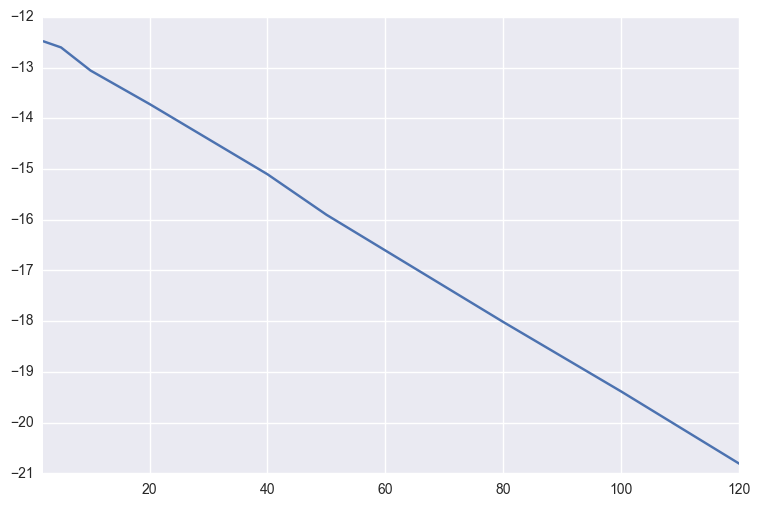

In [78]:
perplexities["log perplexity"].plot()

This measure given by gensim doesn't seem to help us at all because it almost linearly decreases with number of topics...

# Bonus : NetworkX Graph

> BONUS: build the communication graph (unweighted and undirected) among the different email senders and recipients using the NetworkX library. Find communities in this graph with community.best_partition(G) method from the community detection module. Print the most frequent 20 words used by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA? Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

We'll first import the necessary packages

In [79]:
import networkx as nx
import community

In [80]:
G=nx.Graph()

Defining edges

In [81]:
edges_df = pd.read_csv("hillary-clinton-emails/Emails.csv")[["Id","MetadataFrom", "MetadataTo"]].set_index("Id")
edges = [tuple(e) for e in edges_df.to_records(index=False)]

Defining nodes

In [82]:
nodes = list(set([item for sublist in edges for item in sublist]))

Feed the graph

In [83]:
G.add_nodes_from(nodes)
G.add_edges_from(edges)

Find the communities

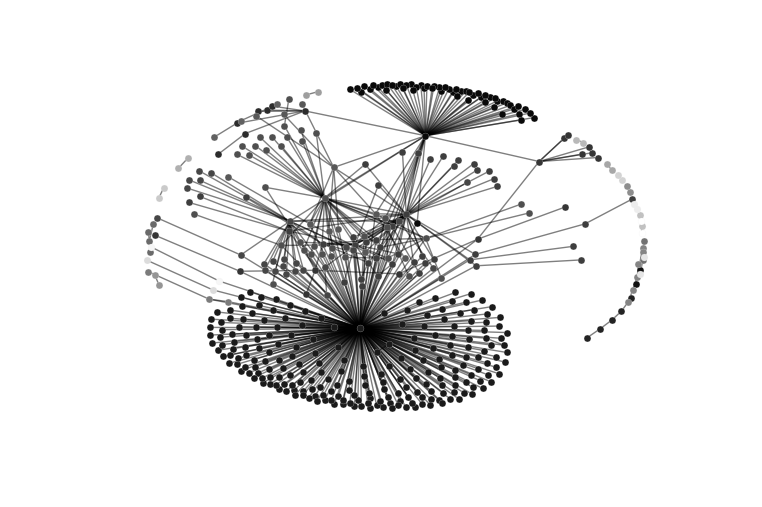

In [84]:
#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)

for count, com in enumerate(set(partition.values())) :  # iterate over communities
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 25,
                                node_color = str((count+1) / size))


nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.axis('off')
plt.show()

We can see there are 3 or 4 main communities, the rest is "spread everywhere". That highlights a few nodes (politicians probably) that are in the middle of a lot of connections

Let's see the repartition of communities

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ebc3588>]], dtype=object)

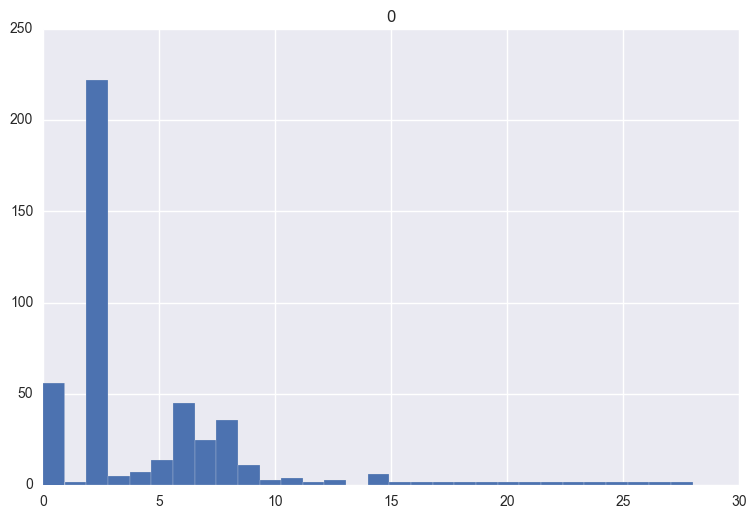

In [85]:
pd.DataFrame(list(partition.values())).hist(bins=30)

Most are in the community called "2" by our algorithm



> Print the most frequent 20 words used by the email authors of each community

We do so building a function `get_top_20_frequent_word()`

In [86]:
data = pd.read_csv("data.csv", index_col=0)[["Lemma"]]
data = data.join(edges_df)

In [87]:
data = data.reset_index()

In [88]:
def get_top_20_frequent_words(txt):
    """ from a string, returns the 20 most frequent words """
    import operator
    wordcount = [txt.count(w) for w in txt.split()] 
    wordcount_pair = dict(set(zip(txt.split(), wordcount)))
    sorted_pair = sorted(wordcount_pair.items(), key=operator.itemgetter(1))[::-1]
    return [w for w,_ in sorted_pair if len(w)>3][:20]

Now let's print these words for all communities emails

In [89]:
for com in set(partition.values()) :  # iterate over communities
    community_full = ""
    list_authors = list(set([nodes for nodes in partition.keys() if partition[nodes] == com]))
    print("\n-- Community ", com, "--\n")
    for author in list_authors:  # iterate over authors of that community
        try:
            author_txt = " ".join(data.set_index("MetadataFrom").loc[author].Lemma.values)  # get all the emails
            community_full += author_txt
        except:
            pass       
    print(" ".join(get_top_20_frequent_words(community_full)))


-- Community  0 --



-- Community  1 --



-- Community  2 --

tate oman state woman will part port pres afgh work afghan side rate thank time comm call nation form eric

-- Community  3 --



-- Community  4 --



-- Community  5 --

clinton state will side part secret secretary obama president policy talk mess come email jake administration pakistan form first message

-- Community  6 --

state will part comm pres side secretary call work house resident depart make president clinton nation mini time just form

-- Community  7 --

call will state need want 2009 deliver mail email speech sent cheryl discus list work also conf blackberry clinton mill

-- Community  8 --

state will port part work conf comm nation secretary diplomacy ally rate side 2010 haiti conflict time public able depart

-- Community  9 --

will pakistan work woman side pres bill even part time afghan state nation right strobe make support reside india ally

-- Community  10 --



-- Community  11 --



-- Communi

> Do these word lists look similar to what you've produced at step 3 with LDA? Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

Using the graph analysis, we have __10 main communities__ that get detected. When displaying the most occurrent words within these communities emails, we can see that they are not the same between communities but that __doesn't enable us to highlight topics as LDA did in the last part.__